# Практическая работа 2. Исследование атак на модели ИИ. FGSM

Картунчиков Артем ББМО-01-23

## Загрузка обученной модели

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0
test_labels = to_categorical(test_labels)
model = tf.keras.models.load_model('../mnist_model.h5')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy on clean images: {test_acc}")

2024-10-17 21:10:59.645262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 21:10:59.661916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 21:10:59.681719: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 21:10:59.687428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 21:10:59.702073: I tensorflow/core/platform/cpu_feature_guar

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1729188664.640897    5871 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-17 21:11:04.677162: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9736 - loss: 0.0915
Test accuracy on clean images: 0.9768000245094299


# Атака FGSM

In [2]:
import numpy as np

# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению
    perturbed_image = image + epsilon * np.sign(gradient)
    # Обрезка значений, чтобы они оставались в пределах [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image
# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    # Превращение изображения в формат, подходящий для модели
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)  
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    # Получение градиента по отношению к входному изображению
    gradient = tape.gradient(loss, image)
    # Применение FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

epsilon = 0.1 # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0],
test_labels[0], epsilon)

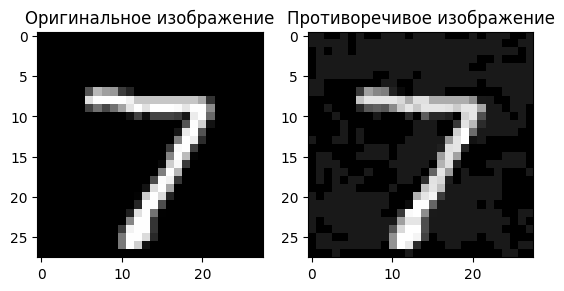

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

In [6]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28,28))
    adversarial_images = np.array(adversarial_images)
    return adversarial_images

# Генерация противоречивых примеров

adversarial_images = generate_adversarial_dataset(model, test_images, test_labels,
epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images,  test_labels)
print(f'Accuracy on adversarial examples: {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0789 - loss: 6.8196
Accuracy on adversarial examples: 0.09910000115633011


## Вывод

В результате проведения FGSM-атаки точность модели снизилась с 97.6% до 9.9%, что подтверждает успешность атаки и уязвимость модели к атакующим примерам.